## **CV PROJECT**
- By Najeeb Saiyed
- Godcares
- Ankit

In [1]:
import os
import cv2
import random
import itertools
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.utils import to_categorical, plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras import layers, regularizers, optimizers, callbacks
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import cv2
import numpy as np
import matplotlib.pyplot as plt


Using TensorFlow backend.


# Preprocessing

### Load the raw dataset, and resize the images so that they can fit CNN's input_shape.

In [2]:
import os
import cv2

img_size = 96

def load_data(path, train=True):
    print("Loading data from:", path)
    data = []
    for img in os.listdir(path):
        imgname, ext = os.path.splitext(img)
        ID, etc = imgname.split('__')
        ID = int(ID) - 1  # to_categorical encodes starting from 0
        if train:
            _, lr, finger, _, _ = etc.split('_')
        else:
            _, lr, finger, _ = etc.split('_')
        if lr == 'Left':
            base = 0  # left hand corresponding to 0-4
        else:
            base = 5  # right hand corresponding to 5-9
        if finger == "little":
            fingerNum = base + 0
        elif finger == 'ring':
            fingerNum = base + 1
        elif finger == 'middle':
            fingerNum = base + 2
        elif finger == 'index':
            fingerNum = base + 3
        else:
            fingerNum = base + 4
        img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)

        img_array = cv2.GaussianBlur(img_array, (3, 3), 0)
        
        # Apply adaptive thresholding filter
        img_array = cv2.adaptiveThreshold(img_array, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                          cv2.THRESH_BINARY, 11, 2)
        
        img_resize = cv2.resize(img_array, (img_size, img_size))
        data.append([ID, fingerNum, img_resize])
    return data


In [6]:
Altered_path = "../input/socofing/SOCOFing/Altered/Altered-"
Real_path = "../input/socofing/SOCOFing/Real"

Easy_data = load_data(Altered_path+'Easy', train=True)
Medium_data = load_data(Altered_path+'Medium', train=True)
Hard_data = load_data(Altered_path+'Hard', train=True)
Real_data = load_data(Real_path, train=False)

Altered_data = np.concatenate([Easy_data, Medium_data, Hard_data], axis=0)


Loading data from: ../input/socofing/SOCOFing/Altered/Altered-Easy
Loading data from: ../input/socofing/SOCOFing/Altered/Altered-Medium
Loading data from: ../input/socofing/SOCOFing/Altered/Altered-Hard
Loading data from: ../input/socofing/SOCOFing/Real


In [7]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, optimizers

# Preprocess Real data
X_real = np.array([item[2] for item in Real_data])
X_real = X_real.reshape(-1, img_size, img_size, 1) / 255.0  # Normalize
y_real = np.ones(len(X_real))  # Labels for real data (1)

# Preprocess Altered data
X_altered = np.concatenate([np.array([item[2] for item in dataset]) for dataset in [Easy_data, Medium_data, Hard_data]])
X_altered = X_altered.reshape(-1, img_size, img_size, 1) / 255.0  # Normalize
y_altered = np.zeros(len(X_altered))  # Labels for altered data (0)

# Combine real and altered data
X_combined = np.concatenate([X_real, X_altered])
y_combined = np.concatenate([y_real, y_altered])

# Optionally, split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_combined, y_combined, test_size=0.2, random_state=42)


In [10]:
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras import regularizers

# Define model architecture
model = models.Sequential()
model.add(layers.Conv2D(32, (5, 5), activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=(96, 96, 1)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D((2, 2)))
model.add(layers.Conv2D(64, (5, 5), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D((2, 2)))
model.add(layers.Dropout(0.3))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(2, activation='softmax'))  # Binary classification (real vs altered)

# Compile model
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss="sparse_categorical_crossentropy",  # Use sparse categorical crossentropy for binary classification
              metrics=["accuracy"])
model.summary()

# Define callbacks
early_stopping = callbacks.EarlyStopping(monitor='val_accuracy', patience=10, mode='max', verbose=1)
reduce_lr = callbacks.ReduceLROnPlateau(factor=0.1, patience=1, min_lr=1e-9, verbose=1)
callbacks_list = [early_stopping, reduce_lr]

# Train model
history = model.fit(X_train, y_train,
                    batch_size=32,
                    epochs=20,
                    validation_data=(X_val, y_val),
                    verbose=1,
                    callbacks=callbacks_list)


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 92, 92, 32)        832       
_________________________________________________________________
batch_normalization_6 (Batch (None, 92, 92, 32)        128       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 46, 46, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 42, 42, 64)        51264     
_________________________________________________________________
batch_normalization_7 (Batch (None, 42, 42, 64)        256       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 21, 21, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 19, 19, 128)      

Test Loss: 0.16947734355926514
Test Accuracy: 96.53518795967102 %


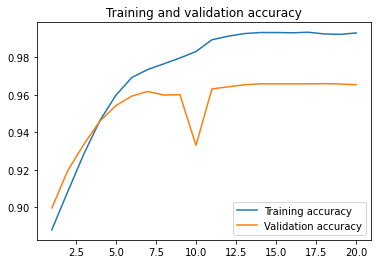

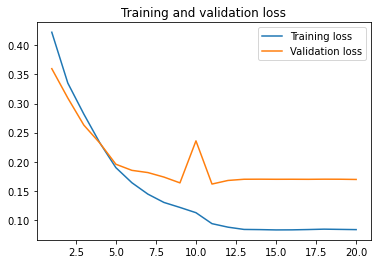

In [17]:
import matplotlib.pyplot as plt

# Extracting training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plotting figures for the model
plt.figure()
plt.plot(epochs, acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

# Evaluate model on test data
testing_loss, testing_acc = model.evaluate(X_val, y_val, verbose=0)
print("Test Loss:", testing_loss)
print("Test Accuracy:", testing_acc * 100, "%")

# Show plots
plt.show()


### Visulize the predictions' of fingername to get a intuitional conclusion about how the model worked.

Test Loss: 0.16947734355926514
Test Accuracy: 96.53518795967102 %


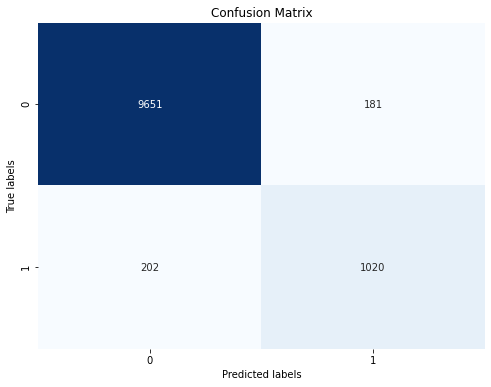

In [23]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras import regularizers

# Define your model, compile, and train it as you did before

# Evaluate model on test data
testing_loss, testing_acc = model.evaluate(X_val, y_val, verbose=0)
print("Test Loss:", testing_loss)
print("Test Accuracy:", testing_acc * 100, "%")

# Generate predictions
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)

# Create confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()


In [24]:
model.save("model_real_and_altered_classifier.h5".format(1))